<h1><center> DataCamp Business Case <br> Kickstarter - Predicting success of fundraising </center></h1>

<h3>  <p style="text-align:left;">Authors : <span style="float:right;"> Professors:<br>  <br> Alexandre GRAMFORT <br> Balazs KEGL<br> <br> <br>
</span></p>

<br> Hamza Filali Baba <br> Eulalie Formery<br> 

Damien Grasset <br>  Alice Guichenez <br> Hugo Perrin</h3>



M2 DataScience - Université ParisScalay
 

***

<img src="img/kickstarter-logo.png" width="600">

## <a href="#1.-Business-case" style="color:#00925B">1.&nbsp;&nbsp;Business case </a>

- Context
- Business problem
- Data presentation
- Limits of our approach

## <a href="#2.-Exploration-of-the-data" style="color:#00925B">2.&nbsp;&nbsp;Exporation of the data </a>

- Descriptive statistics

- Data vizualisation


## <a href="#3.-Baseline-model" style="color:#00925B">3.&nbsp;&nbsp;Baseline model </a>


## <a href="#4.-Local-testing-before-submission" style="color:#00925B">4.&nbsp;&nbsp;Local testing before submission  </a>


***

# <a id="#Business-case"  style="color:#00925B">1. Business case</a>

##  <span style="color:#00925B"> 1.1 Context  </span> 
 
Crowdfunding is the practice of funding a project or venture by raising monetary contributions from many people. Today, most of crowdfunding happens online through various websites and Kickstarter is one of the world's largest crowdfunding platforms. Kickstarter is mainly focused on creativity-related projects, in particular in art, music and design. It helps creators to find the resources and support they need to make their projects come real. Kickstarter is a huge global community; 16 million people have brought their contribution to over 150,000 successful projects all over the world. 

##  <span style="color:#00925B"> 1.2 Business problem  </span> 

**Funding model**
 
The platform is based on an all or nothing funding model: project creators choose a deadline and a minimum funding goal, and money is collected only if the project reaches its goal by the deadline. It is a kind of insurance contract. The funding goal is chosen by the project kicker at the beginning and cannot be changed once the project has been launched. Whenever a project reaches the stated goal, the platform takes a 5% fee on the total amount of money collected. When a project fails, the platform does not gain anything. Therefore, it is to the benefit of Kickstarter that most projects are successful in reaching their funding goal by the deadline. Unlike many other platforms for fundraising and investment, Kickstarter claims no ownership over the projects and the work they produce – their profit is entirely based on the 5% fee they receive in case of success.

**Finding**

There is currently a 36.63% overall rate of success, with some categories performing especially well (almost 62% for dance projects) and others particularly poorly (26% only for fashion).

The failure rate is 52.6% and the rest of the projects are canceled or suspended. Our goal is to increase this rate of success based on the finding that some projects are more meant to success than others. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
data = pd.read_csv('data/full_data.csv')

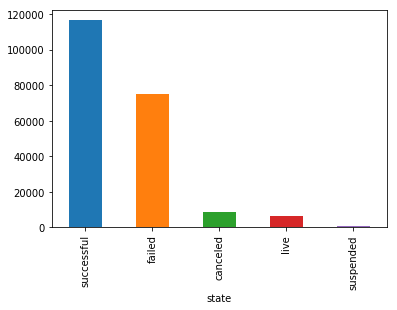

In [4]:
data.groupby('state').count()['id'].sort_values(ascending=False).plot(kind='bar')

The chart below shows that it seems that the projects with highest goals have lower success rates.

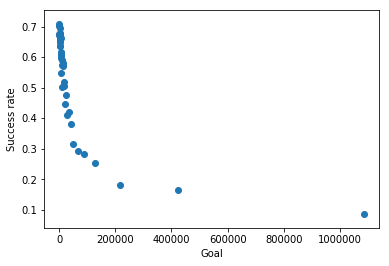

In [8]:
u = data['goal'].unique()
u.sort()

window = 40
intervals = [(u[int(len(u)*i/window)],u[int(len(u)*(i+1)/window)-1]) for i in range(window)]
successes = [len(data.loc[(data.goal <= intervals[i][1]) & (data.goal > intervals[i][0])
         & (data.state=='successful')])/len(data.loc[(data.goal <= intervals[i][1]) & (data.goal > intervals[i][0])]) 
             for i in range(window)]

plt.scatter([intervals[i][1] for i in range(len(intervals))][:-1], successes[:-1])
plt.ylabel("Gold")
plt.xlabel('Goal')
plt.ylabel('Success rate')
plt.show()

Based on these findings according to which the success rate may depend on the attributes of the projects, including the category and the goal among other things, our goal is to increase the success rate by predicting which attributes will make the projects get most chances to be successful.

**Business objective**

Kickstarter will make most money when most projects come to a success. Our objective is therefore to increase the chances of success of the projects by finding the relevant characteristics that will make them most likely to meet the goal by the deadline. By predicting whether a goal will be reached given a certain project, a certain funding target and a certain deadline, we should help fundraisers to pick adequate attributes and increase the rate of success, which should in turn increase Kickstarter’s profit. 

**Users of our solution**

We could sell our solution to Kickstarter and imagine that they would include a kind of recommendation tool in their app, where fundraisers could input the attributes of their project and Kickstarter would provide them guidance to pick the best characteristics given the output probability of success. Project kickers would benefit from a personalized recommendation and accompaniment and Kickstarter would increase its chances to get the 5% fee.

**Prediction task**

Our database is composed of projects along with a short description, their deadlines, their funding target and the actual funds raised. The goal is to predict among new projects which ones will have highest chances of being successful. It is therefore a **multiclass classification task** – failed fundraising, sucessful fundraising (the project has been fundraised in correct proportion) and overfundraising (the project has been too much funded). The result would lead to an ability to provide advice for a better design of the projects, increasing their chances of meeting the target amount by the deadline. 


**Benefits of a machine learning solution**

A machine learning solution is particularly relevant in this context where we can exploit the huge amount of available data to help the business flourish. It makes it possible to emphasize which characteristics would be better suited for each project, it gives the possibility to Kickstarter to provide a personalized accompaniment for the design of fundraising projects and therefore increases the added value of the app by offering an additional service. All in all, it increases the fees gathered by Kickstarter by increasing the rate of success.


**Business metrics**

The prediction task, ie a multiclass classification with three differents output that are :
- The project hasn't been funded - Failed Fundraising
- The project has been funded (in correct proportion) - Successful Fundraising
- The project has been too much funded - Higher Success.

This is where it becomes interesting for Kickstarter to come up with a Key Perfomance Indicator (KPI). Indeed, more than just  having a good accuracy on the prediction, Kickstaster, as all businesses, wants to generate as more profit as it can with the output of the prediction.

Let's imagine a (simple) strategy of goal recommandation from Kickstarer according to the prediction : 
- if we think the goal can be increased (ie predict a Higher Sucess), Kicksarter recommend an increased goal of 20%.
- if, on the contrary, the goal is too large (Failed Fundraising), Kicksarter recommend a decreased goal of 20%.
- if it think it will be successful, the first goal is maintained.


As Kickstarter only receives 5% of the set goal of the project in case of sucess, which is the only revenue it will generate with its plateform, one can see prediction errors in the classification as potential **shortfall** in revenue :

- **(1)** if the project hasn't been 100% funded for a given goal $O_p$, but was pledged only $P_p < O_p$ but Kickstarter has predicted whether a success or a higher success, it means that Kistarted have missed a successful fundraising of $P_p$ for this project, ie :

$$\mbox{loss}_p = 5\% \times 20\% \times O_p \mbox{ if pleged at more than }80\%$$
$$\mbox{loss}_p = 0 \mbox{ if pleged at less than }80\%$$

In practise, as we will talk about it in the data exploration part, there are only few projects that fail to be funded when they reach at least 80% - intuitively, the people in charge of teh project will try to manage to get to 100% so as not to lose all the pledged money so close to the goal. We will then use : $\mbox{loss}_p = 0$

- **(2)** if the project was predicted as a failed fundraising, the goal gets a 20% penalty. Hence, if the project was actually successful or with an higher success, it leads to a loss for Kickstaster : 

$$\mbox{loss}_p = 5\% \times 20\% \times 0_p \mbox{ if success}$$
$$\mbox{loss}_p = 5\% \times 40\% \times 0_p \mbox{ if higher success}$$

- **(3)** If the project was predicted as higher success but was in fact just successful, it means that Kickstarter will lose everything by recommanding an increase in the goal :

$$\mbox{loss}_p = 5\% \times 0_p$$

- **(4)** Finally, if the project was predicted as a normal success but was in fact a higher success, Kistarster loses potentially 20% of the additional amount Kickstarter could have claimed :

$$\mbox{loss}_p = 5\% \times 20\%  \times 0_p$$


Those 4 types of errors are directly connected with the 6 different cell errors in the confusion matrix as you can see below. Not that numbers inside cells are one of the error types listed above.

<img src="img/confusion_matrix.png" width="600">

At the end, we can easily compute a shortfall loss by summing on all the project according to the corresponding error of prediction.

** In practice **:

To build the **shortfall** metric, we decided not to take into account the value of the goal value of project. Indeed, we decided to normalize it to 1 for two reasons : 
- First of all because, it would need to take into account the colomns "goal" of the features dataset and use it inside the score function. But all score metrics in the ramp-workflow have a very precised structure that does not allow easily to put it in argument of the function. Thus, it becomes a *normalize* shortfall of the number of opportunities more than the amount of money it represents. Plus it allows to deal with issues with heterogeneous and values that are not at the same scale - which can have a big impact on the KPI.
- Secondly, because it allows a simpler computation, as it boils down to the following loss formula :

$$ \mbox{shortfall} = 0 \times nb_{type1} +  5\% \times 20\% \times nb_{type2, success} + 5\% \times 40\% \times nb_{type2, higher success} +  5\%  \times nb_{type3} + 5\% \times 20\%  \times nb_{type4}$$

or simply : 

$$ \mbox{shortfall} =  0.05 \times ( 0.2 \times (nb_{type2, success}+  nb_{type4}) + 0.4* \times nb_{type2, higher success} +   nb_{type3}) $$

**Workflow**

In order to download the data, one can run from the terminal : 
```
python data_download.py 
```

If you want to download as well Descriptions or Images (might be a bit long to be downloaded), you can use :

```
python data_download.py --extra images descriptions 
```

**Evolution of our solution in time** 

As new projects are launched, new data becomes available and our model can be improved by benefitting from this increased availability. Furthermore, it could also learn from its past mistakes and successes by evolving as the projects turn out to be failures or successes in accordance with or contrary to the predictions. Consequently, the model will have to be retrained on a regular basis – say once every two months, and this retraining could be based on online learning methods to make it as effective as possible. This would imply additional costs but also increased performance and accuracy for a thriving business.

##  <span style="color:#00925B"> 1.3 Data presentation  </span> 

rep à la question What data cleaning/tidying steps were required to obtain clean training data




To understand the story of the data collection and have all information about it, one is invited to take a look at the *data_sources* folder in the  <a href="https://github.com/EulalieFy/kickstarter-project/tree/master/data_sources">GitHub repository</a>. Here is a summary of it.

We collected the original data from the *webrobots.io* that scrapped the Kickstarter website in huge dataset containing a LOT of information. The data was a bit messy though. Indeed lots of information were hidden in string definition of dictionnary within cells of the dataframe. From this huge dataset and thanks to regex matching tools from instance, we extracted and selected features we consider interesting for the tasks.

From this lighted dataset, we reformated the data in the correct types (datetime, str, etc) and create other variables, dealing with missing value and using standard data processing methods.


**Bonus**:

In addition, we downloaded as well a subset of project images  from url founds in the original dataset, as well as another subset of descriptions - full text of presentation on the home page of a project - thanks to python scrapping packages. All this data is hosted on the same Google Drive as the datasets we will use here. This unstructed and multi-format data (png, txt) are not used in this starting kit but represent an interesting amount of data to use for the task.


##  <span style="color:#00925B"> 1.4 Limits of our approach  </span> 

A first limit of our approach comes from the fact that the data we got is probably not enough to explain the successful aspect of the fundraising all by itself. Further data including detailed project description and information about the project kicker (how many projects they already launched and how many of them were successful, host country of the project, etc) would certainly have been useful. 
Another limit is that we only know if the projects are successful in the sense that the money has been collected or not. However, this should not be the only point of focus because it does not guarantee that once the funds have been collected, the project will be properly implemented: for example, if our model recommends lowering the target amount to get higher chances to collect the money, maybe this amount will underestimate the actual requirements of the project and it will not be realizable. Our point of view was to focus on the profit aspect of the business, but the success of the project once the money has been collected might be relevant to Kickstarter’s business as well. The ideal would have been to have further data about the success of the realization of the project itself and not of the collection of the funds only.

# <a style="color:#00925B">2. Exploration of the data</a>

## <a style="color:#00925B">2.1 Descriptive statistics</a>

In our data exploration analysis, we are interested in analyzing the statistics of successful and failed projects because we would like to underline potential indicators that might differentiate successful and failed project. 

In [13]:
data.drop('Unnamed: 0', inplace=True, axis=1)
# Vizualise the head of the dataframe
data.head(5)

,id,name,short_description,country,city,state_location,main_category,category,created_at,launched_at,...,project_we_love,image_available,description_available,goal,pledged,achieved (%),usd_pledged,static_usd_rate,usd_type,state
0,1555581815,Big Top Without Borders,A documentary about two circuses in remote cor...,US,Boston,MA,film & video,documentary,2012-06-12 20:30:42,2012-10-19 17:30:29,...,False,True,True,25000.0,27455.55,109.8222,27455.55,1.000000,international,successful
1,583419300,"The Story of ""Pweep"": From Egg - To Peacock",A multi-media IPad book telling the true story...,US,Orlando,FL,publishing,children's books,2012-11-03 12:10:26,2012-11-19 21:39:04,...,False,True,True,500.0,535.00,107.0000,535.00,1.000000,international,successful
2,1745190062,DC Radio,We are college students that get drunk and the...,CA,Toronto,ON,journalism,audio,2014-11-13 23:20:56,2014-11-18 16:20:11,...,False,True,True,3500.0,0.00,0.0000,0.00,0.886698,domestic,failed
3,1995203117,Ali Bangerz- two New Full Lenght Albums,"its Ali bangerz,its time to stand up for other...",US,Orlando,FL,music,world music,2015-11-04 20:18:23,2015-11-04 22:22:47,...,False,True,True,20000.0,0.00,0.0000,0.00,1.000000,domestic,failed
4,359013399,Deja-Vu: Dissecting Memory on Camera,A young neuroscientist attempts to reconnect w...,US,Brooklyn,NY,film & video,documentary,2010-09-09 05:38:56,2010-09-09 16:30:14,...,True,True,True,5000.0,6705.00,134.1000,6705.00,1.000000,international,successful


In [5]:
# Shape of the data
print("Data shape", data.shape)

# Column types of the data
data.dtypes

Data shape (207226, 26)


id                         int64
name                      object
short_description         object
country                   object
city                      object
state_location            object
main_category             object
category                  object
created_at                object
launched_at               object
state_changed_at          object
deadline                  object
currency                  object
country.1                 object
creator_name              object
creator_id                 int64
project_we_love             bool
image_available             bool
description_available       bool
goal                     float64
pledged                  float64
achieved (%)             float64
usd_pledged              float64
static_usd_rate          float64
usd_type                  object
state                     object
dtype: object

The data is therefore mainly composed of categorical variables, with only a few numerical variables. This is inherent to our database which must contain the names and descriptions of the projects, and we will handle some of the categorical variables with dummies variables and, when the text is relevant for prediction, we will do NLP.

The average lengths of the names and the descriptions of the projects is below.

In [8]:
print('Average length of the names of the projets:', '%.2f'%(np.mean([len(name) for name in data['name']])))
print('Average length of the descriptions of the projects:', '%.2f'%(np.mean([len(desc) for desc in data['short_description'] if isinstance(desc, str)])))

Average length of the names of the projets: 35.48
Average length of the descriptions of the projects: 113.90


In [9]:
for col in ['country', 'city', 'category', 'currency']:
    print('The number of unique values of ' + col + ' is ' + str(len(data[col].unique())) + '.')

The number of unique values of country is 22
The number of unique values of city is 12650
The number of unique values of category is 159
The number of unique values of currency is 14


In [10]:
print('The projects are therefore based in '+ str(len(data['country'].unique())) + ' countries and are in ' + str(len(data['currency'].unique())) + ' currencies.')

The projects are therefore based in 22 countries and are in 14 currencies.


In [11]:
from collections import Counter
print('The main hosting country for the projects is the ' + str(max(Counter(data['country']))) + ' with over ' + '%.1f'%(100*Counter(data['country'])[max(Counter(data['country']))]/len(data)) + '% of the projects.')
print('The most represented category is ' + str(max(Counter(data['category'])))  + ' but it only represents ' + '%.1f'%(100*Counter(data['category'])[max(Counter(data['category']))]/len(data)) + '% of the projects.')

The main hosting country for the projects is the US with over 78.2% of the projects.
The most represented category is zines but it only represents 0.2% of the projects.


The table below is an overall exploratory data analysis to help us find trends within successes and failures.

In [92]:
data['Target'] = np.where(data['pledged']>=data['goal'], 'success', 'failure')
data['launched_date'] = pd.to_datetime(data['launched_at'], format='%Y-%m-%d %H:%M:%S')
data['deadline_date'] = pd.to_datetime(data['deadline'], format='%Y-%m-%d %H:%M:%S')
data['year'] = [d.year for d in data['launched_date']]
data['month'] = [d.month for d in data['launched_date']]

descriptive_df = pd.DataFrame(np.zeros((11,3)))
descriptive_df.index = ['Projects', 'Proportion (%)', 'Project goal total', 'Project goal average', 'Amount pledged', 
                        'Average pledged', 'Goal vs pledged (%)', 'Average duration',
                        'Average length of the description', 'Nb of labels project_we_love', 'Nb of images']
descriptive_df.columns = ['Successful', 'Failed', 'Total']

sub_df = data[(data.state=='successful') | (data.state=='failed')] 
df_successful = data.loc[data['state']=='successful']
df_failed = data.loc[data['state']=='failed']

for i, df in enumerate([df_successful, df_failed, sub_df]):
    descriptive_df.iloc[0, i] = str(len(df))
    descriptive_df.iloc[1, i] = '%.2f'%(len(df) / len(sub_df) * 100)
    descriptive_df.iloc[2, i] = '%.2f'%(sum(df['goal']))
    descriptive_df.iloc[3, i] = '%.2f'%(df['goal'].mean())
    descriptive_df.iloc[4, i] = '%.2f'%(sum(df['pledged']))
    descriptive_df.iloc[5, i] = '%.2f'%(df['pledged'].mean())
    descriptive_df.iloc[6, i] = '%.2f'%(sum(df['pledged'])/sum(df['goal'])*100)
    descriptive_df.iloc[7, i] = '%.2f'%(df['duration'].mean())
    descriptive_df.iloc[8, i] = '%.2f'%(df['short_description'].apply(lambda x: len(x)).mean())
    descriptive_df.iloc[9, i] = str(sum(df['project_we_love']))
    descriptive_df.iloc[10, i] = str(sum(df['image_available']))
    
descriptive_df

,Successful,Failed,Total
Projects,115126,74959,190085
Proportion (%),60.57,39.43,100.00
Project goal total,1224191119.49,6500514085.47,7724705204.96
Project goal average,10633.49,86720.93,40638.16
Amount pledged,2619416480.88,113129963.60,2732546444.48
Average pledged,22752.61,1509.22,14375.39
Goal vs pledged (%),213.97,1.74,35.37
Average duration,32.48,34.70,33.35
Average length of the description,114.97,113.82,114.52
Nb of labels project_we_love,24450,2604,27054


In [99]:
print('The goal of successful projects is in average ' + str(int(df_failed['goal'].mean()/df_successful['goal'].mean())) + ' times lower than for failed projects.')

The goal of successful projects is in average 8 times lower than for failed projects.


Therefore, our databases contains more successful projects than failed projects. The goal is in average far **lower** for successful projects. The length of the description is slightly bigger for successful projects but the difference is very low. However, the number of images is far **higher**, which means that the presence of an image with the project may increase the chances of success. As for the label *project_we_love*, it certainly is of great importance in the success of projects since the number of such labels is far higher for successful projects. This label is added by Kickstarter for the projects they want to support, and its influence is obviously non neglectable - one can imagine that people who are unsure who they want to give money to would be influenced a lot by this label.

The boxplot below shows that successful projects have **shorter** duration.

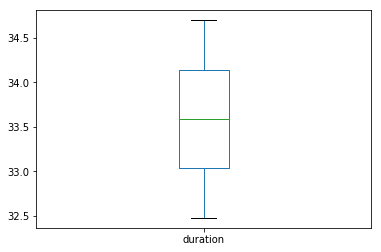

In [83]:
data['duration'] = data['deadline_date'] - data['launched_date']
data['duration'] = data['duration'].apply(lambda x: x.days)
#sub_data = data.loc[(data.state=='successful') or (data.state=='failed')]
sub_data = data[(data.state=='successful') | (data.state=='failed')] 
sub_data.groupby('state').duration.mean().sort_index().plot(kind='box')

In [84]:
print('Successful projects have an average duration of ' + '%.2f'%(data.groupby('state').duration.mean()['successful']) + ' days and failed projects have an average duration of ' + '%.2f'%(data.groupby('state').duration.mean()['failed'])+ ' days.')

Successful projects have an average duration of 32.48 days and failed projects have an average duration of 34.70 days.


## <a style="color:#00925B">2.2 Data vizualisation</a>

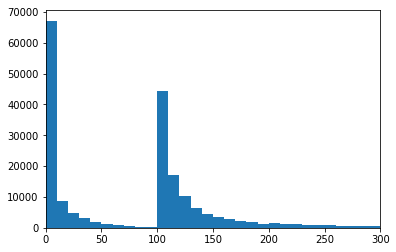

In [12]:
plt.xlim((0,300))
plt.hist(data['achieved (%)'], bins=1000, range=(0,10000))
plt.show()

The histogram above shows that there seems to be trends in the percentage of the target gathered in the end depending on the amount. We can identify three trends: one with the amounts below 100, one with the amounts between 100 and 120 because of the thresholds at 100 and 120, and one with the amounts above 120. Hence the idea of a multiclass classification with three classes of amounts - below 100, between 100 and 120, and above 120.

The chart below shows the state of the projects.

The 15 most represented categories are represented below:

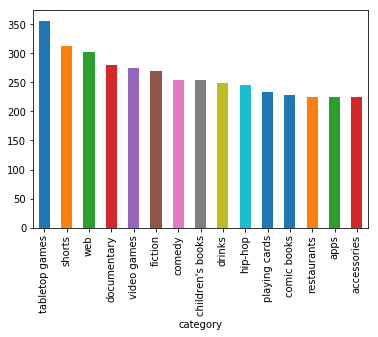

In [74]:
data.groupby('category').count()['id'].sort_values(ascending=False)[:15].plot(kind='bar')

The repartition of the projects within the years is the following:

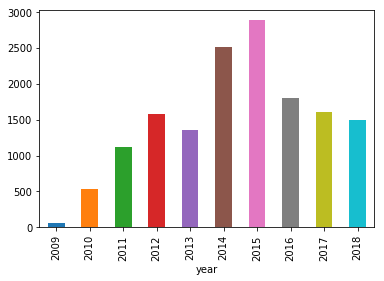

In [79]:
data.groupby('year').count()['id'].plot(kind='bar')

In the histogram below, we see that the year with the highest failure ratio is 2015, while 2012 seems to have a high success ratio.

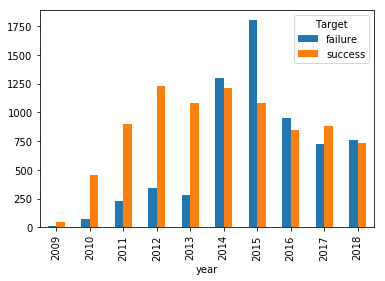

In [88]:
data.groupby(['year','Target']).count()['id'].unstack().plot(kind='bar')

The chart below shows that there is variability in the difference between goal and pledged among the categories that pledged most money. Some of them only gather a total amount just above the goal, while some others gather an amount far above the goal. 

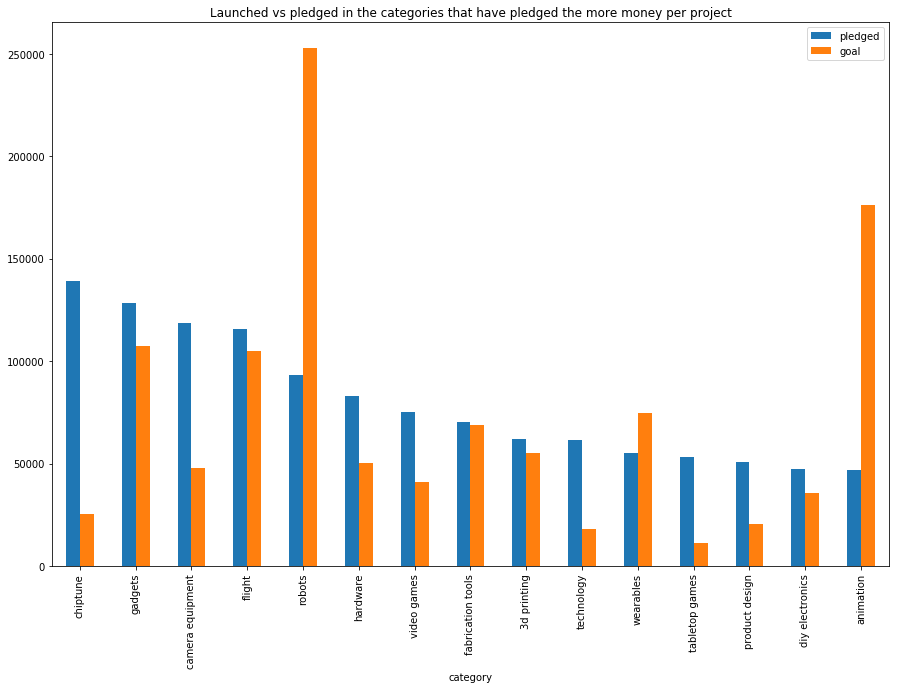

In [89]:
data.groupby('category')['pledged','goal'].mean().sort_values(by='pledged',ascending = False)[:15].plot(kind='bar', figsize=(15,10), title='Launched vs pledged in the categories that have pledged the more money per project')

#  <a style="color:#00925B">3. Baseline model</a>

#  <a style="color:#00925B">4. Local testing before submission</a>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1)

## Modules

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec

from gensim.models import Doc2Vec
from scipy.spatial import distance
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance
from sklearn.base import BaseEstimator

from problem import get_train_data, get_test_data
from problem import metric_report

##  Load and clean data

In [3]:
data = pd.read_csv('../kickstarter-bis/data/test.csv')
data = data.dropna(subset=['name'])

data.index = np.arange(0, len(data))

In [4]:
## To do before in the "problem.py"

labels = data['pledged']
data.drop(['pledged', 'state', 'usd_pledged_real', 'pledged', 'usd pledged', 'backers'], 
          axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Feature extractor

In [ ]:
# %load submissions/baseline/feature_extractor.py

import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import string

# remove dashes and apostrophes from punctuation marks 
punct = string.punctuation.replace('-', '').replace("'",'')
# regex to match intra-word dashes and intra-word apostrophes
my_regex = re.compile(r"(\b[-']\b)|[\W_]")

def clean_string(string, punct=punct, my_regex=my_regex, to_lower=False):
    if to_lower:
        string = string.lower()
    # remove formatting
    str = re.sub('\s+', ' ', string)
     # remove punctuation
    str = ''.join(l for l in str if l not in punct)
    # remove dashes that are not intra-word
    str = my_regex.sub(lambda x: (x.group(1) if x.group(1) else ' '), str)
    # strip extra white space
    str = re.sub(' +',' ',str)
    # strip leading and trailing white space
    str = str.strip()
    return str

class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X, y):
        
        #### NLP BASICS ####
        X['name'] = X['name'].fillna('non available')
        X['short_description'] = X['short_description'].fillna('non available')
        names = X['name'].tolist()
        description = X["short_description"].tolist()
        
        cleaned_project_names = []
        
        for idx, doc in enumerate(names):
            # clean
            doc = clean_string(doc, punct, my_regex, to_lower=True)
            # tokenize (split based on whitespace)
            tokens = doc.split(' ')
            # remove digits
            tokens = [''.join([elt for elt in token if not elt.isdigit()]) for token in tokens]
            # remove tokens shorter than 3 characters in size
            tokens = [token for token in tokens if len(token) > 1]
            # remove tokens exceeding 25 characters in size
            tokens = [token for token in tokens if len(token) <= 25]
            cleaned_project_names.append(tokens)
            
        cleaned_description = []

        for idx, doc in enumerate(description):
            doc = clean_string(doc, punct, my_regex, to_lower=True)
            tokens = doc.split(' ')
            tokens = [''.join([elt for elt in token if not elt.isdigit()]) for token in tokens]
            tokens = [token for token in tokens if len(token)>3]
            tokens = [token for token in tokens if len(token)<=25]
            cleaned_description.append(tokens)
    
        cleaned_total = cleaned_project_names.copy()

        for a in cleaned_description:
            cleaned_total.append(a)
            
        ##### Train Word2vec 
        self.model = Word2Vec(cleaned_project_names, min_count=1, size=100, workers=8)
        
        return self

    def transform(self, X):
        
        data = X.copy()
        
        #### SIMPLE TRANSFORMATION #### 
        
        ### Date features
        data['launched_date'] = pd.to_datetime(data['created_at'], format='%Y-%m-%d %H:%M:%S')
        data['deadline_date'] = pd.to_datetime(data['deadline'], format='%Y-%m-%d %H:%M:%S')
        data['length'] = data['deadline_date'] - data['launched_date']
        data['length'] = [d.days for d in data['length']]
        data['year'] = [d.year for d in data['launched_date']]
        data['month'] = [d.month for d in data['launched_date']]
        data['day'] = [d.day for d in data['launched_date']]
        
        #Change NaN in name and description and reset index
        data.short_description = data.short_description.fillna('not available')
        data.name = data.name.fillna('not available')
        
        # Length of name and description
        data['name_length'] = [len(name) for name in data['name']]
        data['description_length'] = [len(desc) for desc in data['name']]
        data['word_number_name'] = [len(name.split(' ')) for name in data['name']]
        data['word_number_desc'] = [len(desc.split(' ')) for desc in data['short_description']]

        # Ponctuation in name
        data['question'] = (data.name.str[-1] == '?').astype(int)
        data['exclamation'] = (data.name.str[-1] == '!').astype(int)

        # Create dummies for categorical features
        main_category = pd.get_dummies(data['main_category'],prefix='mc')
        category = pd.get_dummies(data['category'], prefix = 'cat')
        country = pd.get_dummies(data['country'], prefix = 'country')
        currency = pd.get_dummies(data['currency'], prefix = 'currency')
        data= pd.concat([data, main_category, category, country, currency], axis=1)
        
        
        #Switch to binary features
        data.description_available = data.description_available.astype(int)
        data.image_available = data.image_available.astype(int)
        data.disable_communication = data.disable_communication.astype(int)
        
        # Drop several features
        names = data['name'].tolist()
        description = data["short_description"].tolist()
    
        features_to_drop = [ 'name', 'short_description', 'country', 'city',
       'state_location', 'main_category', 'category', 'created_at',
       'launched_at', 'state_changed_at', 'deadline', 'currency', 
       'creator_name', 'creator_id', 'project_we_love', 'goal',  
       'launched_date','deadline_date', 'static_usd_rate', 'usd_type']
        data.drop(features_to_drop, axis=1, inplace=True)
  
        #### NLP BASICS ####
        cleaned_project_names = []
      
        for idx, doc in enumerate(names):
            # clean
            doc = clean_string(doc, punct, my_regex, to_lower=True)
            # tokenize (split based on whitespace)
            tokens = doc.split(' ')
            # remove digits
            tokens = [''.join([elt for elt in token if not elt.isdigit()]) for token in tokens]
            # remove tokens shorter than 3 characters in size
            tokens = [token for token in tokens if len(token) > 1]
            # remove tokens exceeding 25 characters in size
            tokens = [token for token in tokens if len(token) <= 25]
            cleaned_project_names.append(tokens)
            
        cleaned_description = []

        for idx, doc in enumerate(description):
            doc = clean_string(doc, punct, my_regex, to_lower=True)
            tokens = doc.split(' ')
            tokens = [''.join([elt for elt in token if not elt.isdigit()]) for token in tokens]
            tokens = [token for token in tokens if len(token)>3]
            tokens = [token for token in tokens if len(token)<=25]
            cleaned_description.append(tokens)
            
        name_matrix = np.zeros((len(cleaned_project_names), 100), dtype="float32")

        for i in range(len(cleaned_project_names)):
            try:
                name_matrix[i,]= self.model.wv[cleaned_project_names[i]].sum(0) / len(cleaned_project_names[i]) 
            except:
                pass
            
        description_matrix = np.zeros((len(cleaned_description),100),dtype="float32")
       
        for i in range(len(cleaned_description)):
            try:
                description_matrix[i,]=self.model.wv[cleaned_description[i]].sum(0)/len(cleaned_description[i]) 
            except:
                pass
       
        name_embeddings = pd.DataFrame(name_matrix)
        name_embeddings = name_embeddings.add_prefix('name_')
        description_embeddings = pd.DataFrame(description_matrix)
        description_embeddings = description_embeddings.add_prefix('desc_')
        
        name_embeddings.set_index(data.index, inplace=True)
        description_embeddings.set_index(data.index, inplace=True)
        data = pd.concat([data, name_embeddings], axis=1)
        data = pd.concat([data, description_embeddings], axis = 1)
        
        return data


## Classifier

In [ ]:
# %load submissions/baseline/classifier.py

import xgboost as xgb
import numpy as np

from sklearn.base import BaseEstimator

class Classifier(BaseEstimator):
    
    def __init__(self):
        self.model = xgb.XGBClassifier(booster = 'gbtree',
                                       objective = 'multi:softmax',
                                       colsample_bytree = 0.9, 
                                       learning_rate = 0.1,
                                       max_depth = 5, 
                                       alpha =10,
                                       n_estimators = 50,
                                       n_jobs=-1)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        prediction = self.model.predict(X)
        return prediction
    
    def predict_proba(self,X):
        prediction = self.model.predict(X)
        probas = np.zeros((X.shape[0],3))
        for ind,c in enumerate(prediction) : 
            probas[ind,c]=1
        return probas

## Else

In [8]:
feature_extractor = FeatureExtractor()

feature_extractor.fit(X_train, y_train)

X_train = feature_extractor.transform(X_train)
X_test = feature_extractor.transform(X_test)

In [9]:
lgb_regressor = Regressor()

lgb_regressor.fit(X_train, y_train)

y_pred = lgb_regressor.predict(X_test)

In [10]:
metric_report(X_test, y_true=y_test, y_pred=y_pred)

-------- REGRESSION METRICS --------

RMSE: 78447.00
MAE: 13146.39

-------- CLASSIFICATION METRICS --------

Accuracy: 0.65
Precision: 0.49
Recall: 0.39


# Local testing with RAMP (before submission)


It is important that you test your submission files before submitting them. For this we provide a unit test. Note that the test runs on your files in submissions/starting_kit, not on the classes defined in the cells of this notebook.

Start install the **ramp-workflow** packages unsing "pip install" or directly from the GitHub repository.

```
pip install ramp-workflow
```

Then you can run 

```
ramp_test_submission --submission starting_kit --ramp_data_dir=./data/
```

If it runs and print training and test errors on each fold, then you can submit the code.

In [ ]:
!ramp_test_submission --submission starting_kit --ramp_data_dir=./data/

# Final word

Does anyone have smthg to say  ?